# Phase separation tutorial
In the first section, we load an artificial two-phase PIV image and then use different phase separation methods to discriminate the two phases and save them as separate images. This section aims to introduce different methods that are available.

In the second section, we demonstrate phase separation on real images followed by actual PIV process as a more realistic example.

# Section 1 - Introducing different methods

## Loading image

In [1]:
from openpiv import tools, phase_separation
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

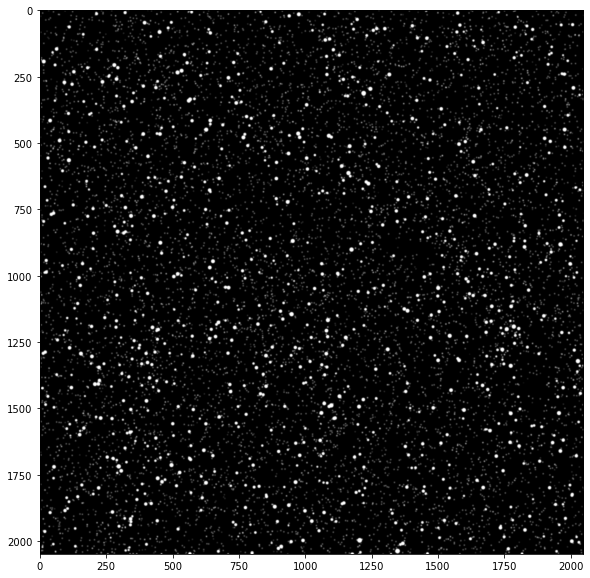

In [2]:
two_phase_image = tools.imread('../two_phase_piv/artificial_A.tif')
plt.figure(figsize=(10,10))
plt.imshow(two_phase_image)
plt.show()

## Opening method

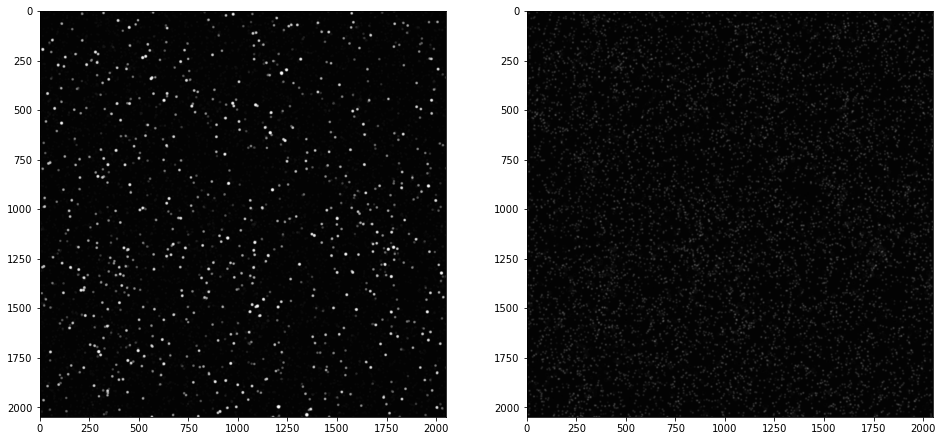

In [3]:
big_particles_image, small_particles_image = phase_separation.opening_method( two_phase_image, 11, thresh_factor=1.05 )
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( big_particles_image, vmin=0, vmax=255 )
ax[1].imshow( small_particles_image, interpolation='bicubic', vmin=0, vmax=255 )
plt.show()

## Median filter method

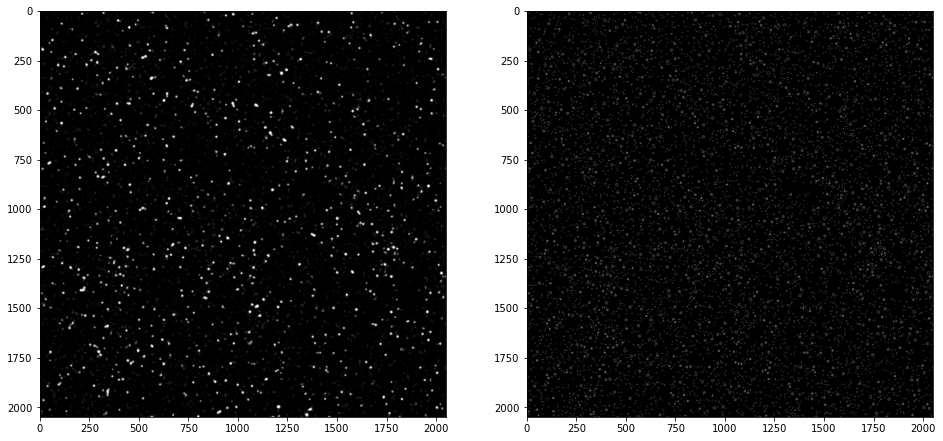

In [4]:
big_particles_image, small_particles_image = phase_separation.median_filter_method(two_phase_image, 11)
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( big_particles_image)
ax[1].imshow( small_particles_image, vmin=0, vmax=255 )
plt.show()

## Khalitov-Longmire method

### Using a simple size limit

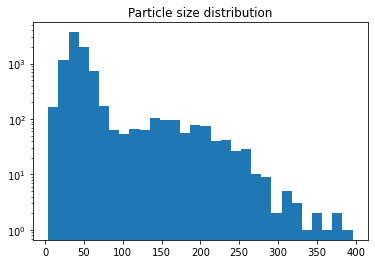

In [5]:
# Plot size distribution
plt.hist( phase_separation.get_particles_size_array(two_phase_image), 30)
plt.yscale('log')
plt.title('Particle size distribution')
plt.show()

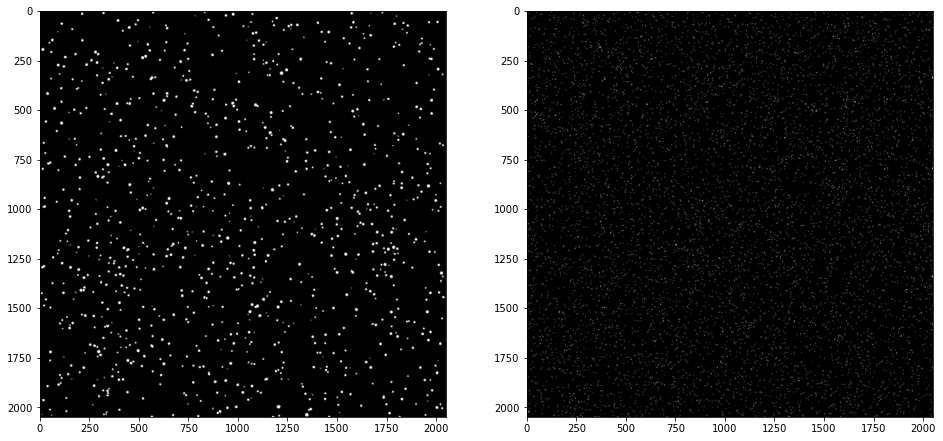

In [6]:
# Choose size limit = 100 
big_particles_criteria = {'min_size' : 75}
small_particles_criteria = {'max_size' : 75}
big_particles_image, small_particles_image = \
    phase_separation.khalitov_longmire( two_phase_image, big_particles_criteria, small_particles_criteria ) 
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( big_particles_image )
ax[1].imshow( small_particles_image )
plt.show()

### Using size and brightness limits

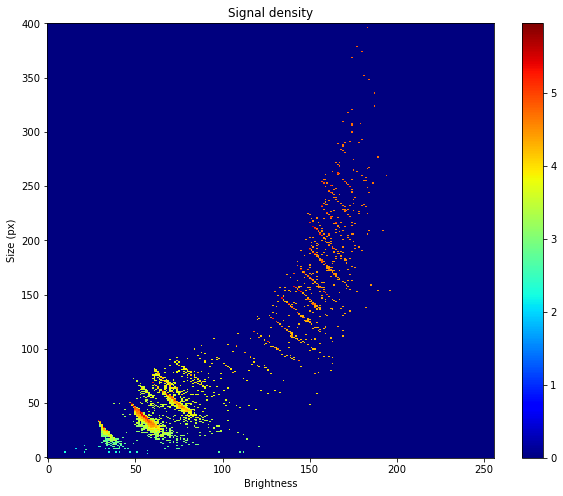

In [7]:
# First plot size-brightness map
sb_map = phase_separation.get_size_brightness_map( two_phase_image ) # It is possible to sum over maps of multiple images
plt.figure(figsize=(10,8))
plt.imshow( sb_map, interpolation='nearest', aspect='auto', origin='lower', cmap='jet' )
plt.colorbar()
plt.xlabel('Brightness')
plt.ylabel('Size (px)')
plt.title('Signal density')
plt.show()

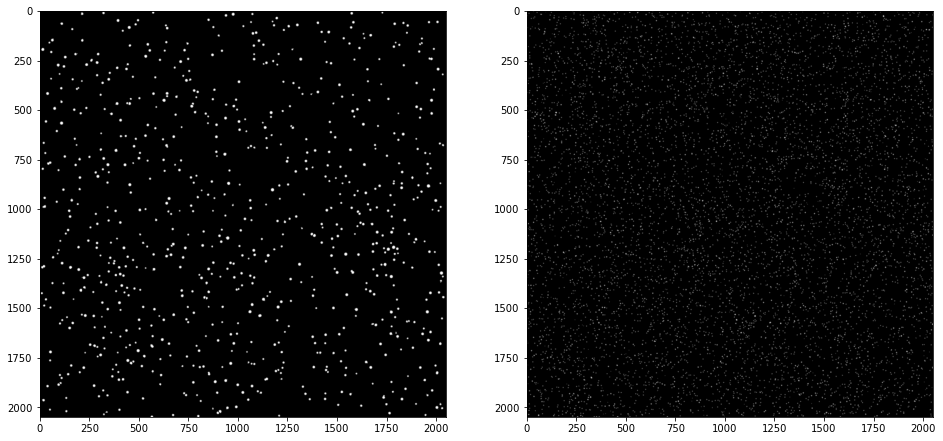

In [8]:
# size-brightness rectangle regions 
big_particles_criteria = {
    'min_size' : 100 ,'max_size' : 350 , 'min_brightness' : 100 , 'max_brightness' : 180 }
small_particles_criteria = {
    'min_size' : 25 ,'max_size' : 100 , 'min_brightness' : 30 , 'max_brightness' : 100}
big_particles_image , small_particles_image = \
    phase_separation.khalitov_longmire( two_phase_image, big_particles_criteria, small_particles_criteria ) 
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( big_particles_image )
ax[1].imshow( small_particles_image )
plt.show()

# Section 2 - Practical example

## Loading image

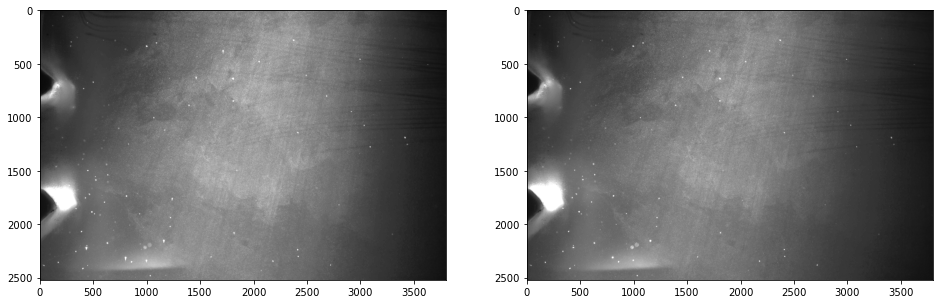

In [9]:
raw_A = tools.imread('../two_phase_piv/real_A.tif')
raw_B = tools.imread('../two_phase_piv/real_B.tif')
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( raw_A )
ax[1].imshow( raw_B )
plt.show()

## Separating phases

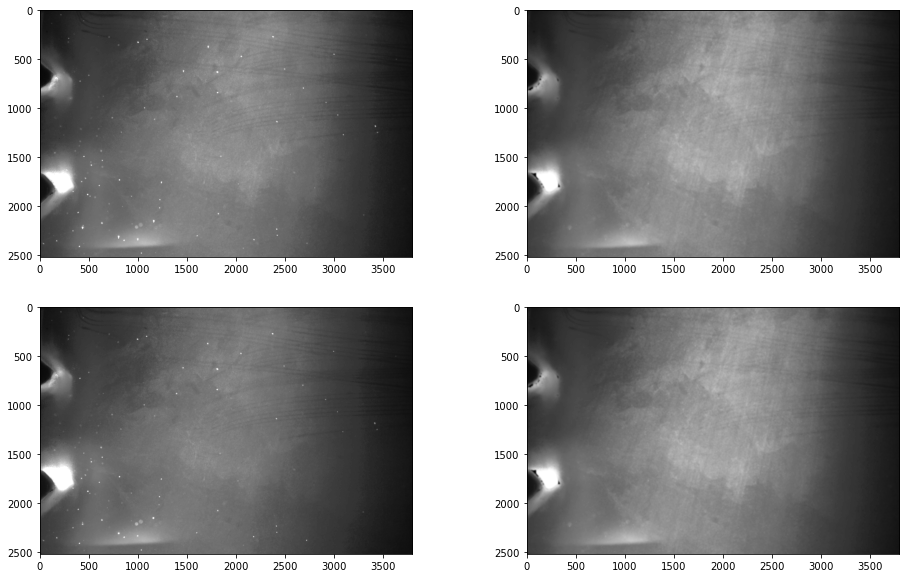

In [10]:
solid_A, carrier_A = phase_separation.opening_method( raw_A, 7, thresh_factor=1.05 )
solid_B, carrier_B = phase_separation.opening_method( raw_B, 7, thresh_factor=1.05 )
fig, ax = plt.subplots(2, 2, figsize=(16,10))
ax[0,0].imshow( solid_A, vmin=0, vmax=255 )
ax[0,1].imshow( carrier_A, vmin=0, vmax=255 )
ax[1,0].imshow( solid_B, vmin=0, vmax=255 )
ax[1,1].imshow( carrier_A, vmin=0, vmax=255 )
plt.show()

## Carrier phase PIV

In [11]:
from openpiv import tools, validation, filters, scaling, process
import numpy as np 

In [12]:
winsize = 48 # pixels
searchsize = 128  # pixels, search in image B
overlap = 24 # pixels
dt = 20e-6 # sec
scaling_factor = 2500 # pixels/meter

u0, v0, sig2noise = process.extended_search_area_piv( carrier_A.astype(np.int32), carrier_B.astype(np.int32),
                subpixel_method ='parabolic', window_size=winsize, 
                overlap=overlap, dt=dt, search_area_size=searchsize, 
                sig2noise_method='peak2peak' )
x, y = process.get_coordinates( image_size=carrier_A.shape, window_size=winsize, overlap=overlap )

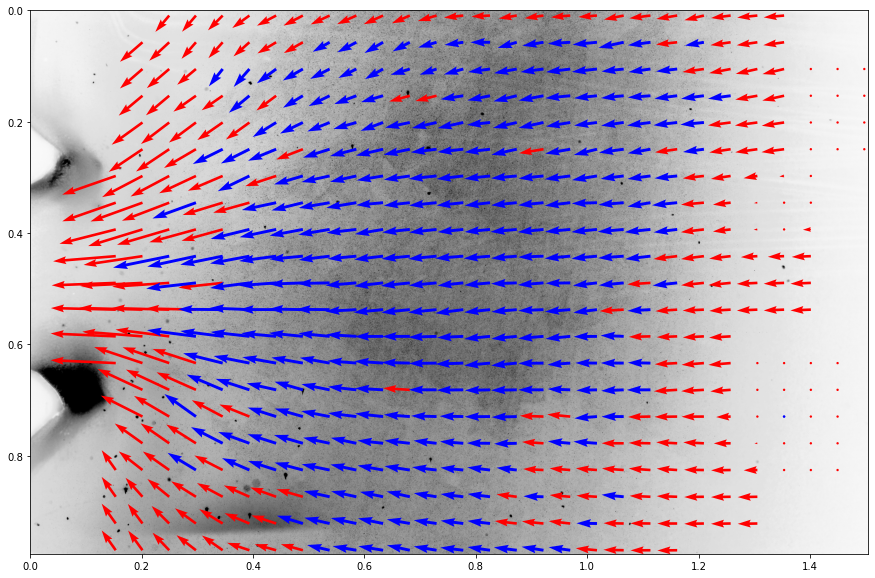

(<Figure size 1152x720 with 1 Axes>, <AxesSubplot:>)

In [13]:
u1, v1, mask = validation.sig2noise_val( u0, v0, sig2noise, w=None, threshold=3.2 )
u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=5, kernel_size=2 )
x, y, u3, v3 = scaling.uniform( x, y, u2, v2, scaling_factor=scaling_factor )
tools.save( x, y, u3, v3, mask, 'data.txt' )
tools.save( x[::5, ::5], y[::5, ::5], u3[::5, ::5], v3[::5, ::5], mask[::5, ::5], 'preview.txt' )
fig, ax = plt.subplots(figsize=(16,10))
tools.display_vector_field( 'preview.txt', on_img=True, image_name='../two_phase_piv/real_A.tif', scaling_factor=scaling_factor, ax=ax )

## Solid phase PTV

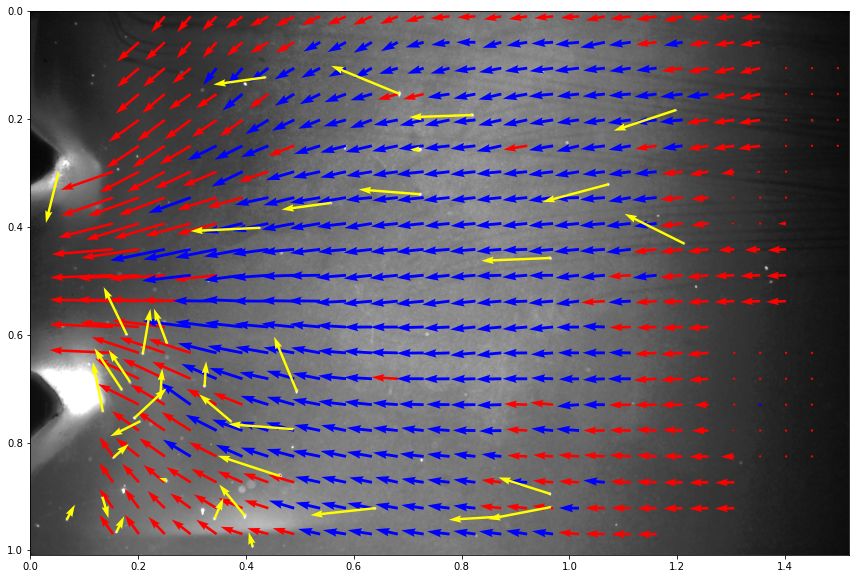

In [14]:
# Note that this is an over-simplified PTV code, just for demonstration.
# Please use OpenPTV or other PTV software for meaningful results.

%matplotlib inline
%config InlineBackend.close_figures=False

import numpy as np
from skimage.measure import label, regionprops
from scipy.spatial.distance import cdist
from IPython.display import clear_output

centers_A = np.asarray([ p.centroid for p in regionprops( label( solid_A > 2 * np.mean(solid_A))) ])
centers_B = np.asarray([ p.centroid for p in regionprops( label( solid_B > 2 * np.mean(solid_B))) ])

cross_distance = cdist( centers_B, centers_A )

PTV_X = []
PTV_Y = []
PTV_U = []
PTV_V = []
for i in range(1, len(centers_A)):
    if np.min(cross_distance, 0)[i] < 5:
        j = np.argmin(cross_distance, 0)[i]
        PTV_X.append( centers_A[i,1]/scaling_factor )
        PTV_Y.append( centers_A[i,0]/scaling_factor )
        PTV_U.append( (centers_B[j,1] - centers_A[i,1])/(scaling_factor * dt) )
        PTV_V.append( -(centers_B[j,0] - centers_A[i,0])/(scaling_factor * dt) )

PTV_X = np.asarray(PTV_X)
PTV_Y = np.asarray(PTV_Y)
PTV_U = np.asarray(PTV_U)
PTV_V = np.asarray(PTV_V)

width = solid_A.shape[1] / scaling_factor 
height = solid_A.shape[0] / scaling_factor 
fig2, ax2 = plt.subplots(figsize=(16,10))
ax2.imshow( solid_A, extent=[0, width, 0, height], origin='lower' )
tools.display_vector_field( 'preview.txt', scaling_factor=scaling_factor, ax=ax2 )
ax2.invert_yaxis()
ax2.quiver( PTV_X, PTV_Y, PTV_U, PTV_V, color='yellow', width=0.003)
ax2.invert_yaxis()
clear_output(wait=True)
plt.show()